## DEEP-SORT Architecture Breakdown
This is a detailed breakdown of how an example implementation of the DEEP SORT algorithm can be applied to a Soccer Clip for the purposes of detecting players and the ball. Each stage from the input video frames up to the final multi-obtject tracking is explained below:

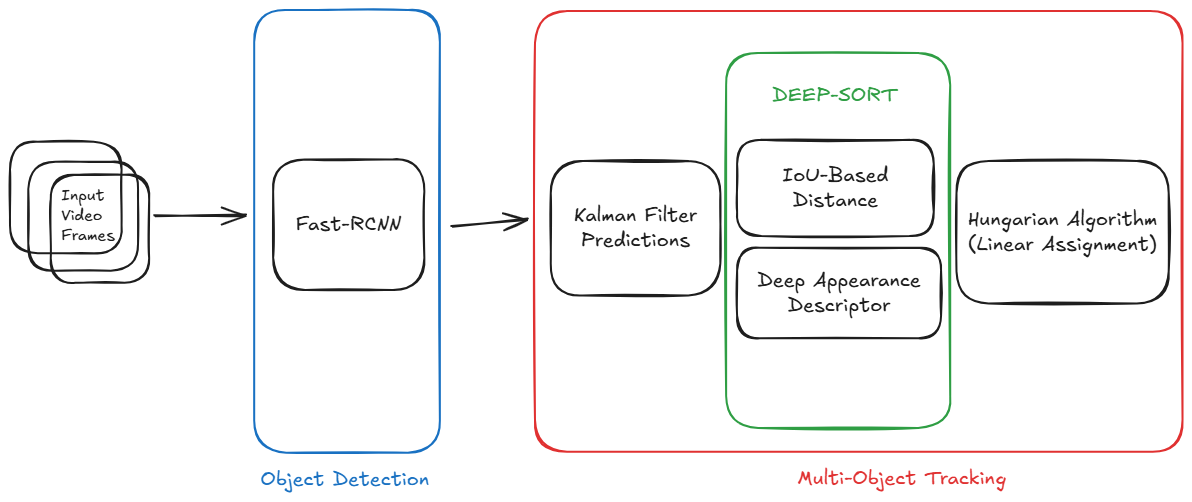

In [4]:
from IPython.display import Image
Image(filename='/workspaces/eng-ai-agents/Assignment5/DeepSORTArch.png')

# 1. Input Video Frames
* The 42 Second Soccer highlights clip is feeded into the initial object detection layer, frame-by-frame
* Each of these individual frames are used to detect the two classes of interest: people and ball
* Bounding boxes are drawn around the objects detected within these individual frames

# 2. Object Detection
* We use the backbone of a Fast-RCNN model pre-trained on the COCO dataset, granting us the abilities to distinguish between different object classes, and for our purposes, the people and ball classes
* The model has two layers of output, with one head preserved for classification of the detected objects, and the other for regressing bounding box coordinates
* Since we're only interested in two classes, the people class is identified with the ID 1 and the ball class is labeled with ID 37
* The output for the bounding box coordinates results in 4 values, reserved for height, width, and a co-ordinate point
* Other object detection models like YOLO can also be used for working alongside the DEEP SORT Algorithm

# 3. Feature Extraction
* For the purposes of multi-object tracking, we need to leverage a Deep Appearance Desciptor, which is essentially an additional neural network/model which extracts detailed features/embeddings from the feature maps produced by the earlier Fast-RCNN object detection model
* In our case, we use a pre-trained ResNET model, rather than a traditional model, that is specifically tuned for image feature/embedding extraction
* The result is a feature vector of high-dimensionality that can distinguish unique objects regardless of any potential overlap or close distance

# 4. Kalman Filter Equations for Predictions
* The Kalman Filters utilize Gaussian probability distributions to keep track of the states of detected objects over a period of time, across any occlusions/obstacles, to ensure consistent tracking of the same objects continues
* It works by combining noisy measurements with a prediction based on the previous state and dynamics of the system, usually a measurement step, which in this case is the IoU-Base distance discussed below
* The equations used for these filters can be divided into two components:
  * Prediction: For estimating the current state of an object given its previous state and environment(measurement obtained later)
  * Update: Adjust its own prediction based on the actual measurement step(distance between current and past object state)
* Prediction Equations:
  * xk- = Fk * xk-1 --> This predicts the next state(vector) of the object based on the state transition model Fk as well as the previous state of the object
  * Pk- = Fk * Pk-1 * FkT + Qk --> This predicts the covariance that represents the uncertainty of the estimated future state
* Update Equations:
  * Kalman Gain: Kk = Pk- * HkT * (Hk * Pk- * HkT + Rk)^-1 --> This denotes the weightage given to the measurements and current-state estimate of an object where Rk is the measurement step noise covariance
  * Updated state: xk = xk- + Kk * (Zk - Hk * xk-) --> Gives the updated state of the object with the actual measurement obtained from Zk, the measurement matrix Hk and the Kalman Gain, Kk
  * Updated covariance: Pk = (I - Kk * Hk) * Pk- --> Gives the updated covariance for the updated state of the object
* It is precisly due to the Kalman filters that object detections can be continued/maintained when they're temporarily lost/occluded in real-time as they leverage the previous state, measurement and Gaussian probability distributions to predict future states/trajectory of any given object

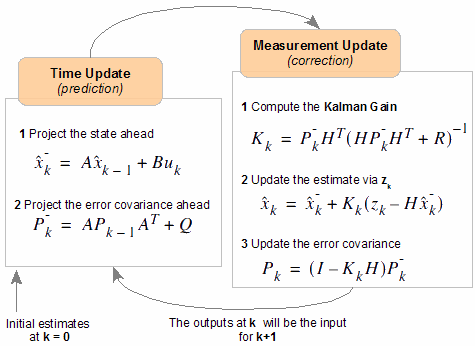

In [5]:
from IPython.display import Image
Image(filename='/workspaces/eng-ai-agents/Assignment5/Kalman.gif')


# 5. IoU-Based Distance Computation
* IoU is used as a key measure of similarity between the predicted location of a track and a newly detected object
* When a new detection is made in each frame, we determine if it corresponds to any existing tracks by comparing the bounding box of each track to the bounding boxes of the new detections using IoU
* We also make use of this distance for the computation of the cost-matrix that is necessary for the Hungarian Algorithm during Data Association
  * Lower IoU → Higher Distance → Higher Cost: A small overlap most likely indicates different objects, so it is unfavorable to match them
  * Higher IoU → Lower Distance → Lower Cost: A large overlap most likely indicates that the track and detection are the same object, and it is favorable to match them

# 6. Hungarian Algorithm (Linear Assignment)
* The algorithm is used to match the detections from a given frame to the existing tracks based on a cost matrix that quantifies the similarity or "cost" of associating each track with each detection
* As previously described in the IoU Distance section, the Hungarian Algorithm's purpose is to minimize the cost function/total assignment cost to determine the best assignment between a detection and tracks
* The cost function/matrix is based on two components we previously covered:
  * IoU-Based Distance Cost
  * Deep Appearance Feature Vector Cost
* The algorithms effectively resutls in three possible results:
  * A detection is matched with a track, so the track is updated
  * A new detection is made and a new corresponding track is initialized
  * A track is deleted/removed if no matching detections are made for several frames